# CS4248 Project - Labelled Unreliable News (LUN)

In [32]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stemmer = None
# lemmatizer = None

TEST_SIZE = 0.1
SMOOTHING = 1.0
NGRAM_RANGE = (1, 1)

[nltk_data] Downloading package wordnet to /Users/allard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Helper Functions

In [33]:
def preprocess(sentence, lower_case=True, remove_punctuation=True):
    if lower_case:
        sentence = sentence.lower()
    if remove_punctuation:
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    return sentence

In [34]:
def tokenize(sentence, stemmer=stemmer, lemmatizer=lemmatizer, remove_stop_words=False):
    tokens = word_tokenize(sentence)
    
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    if lemmatizer:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    return tokens

## Load Data

In [35]:
import pandas as pd

full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
print(len(full_train_df))
full_train_df.head()

48854


,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [36]:
train_df = full_train_df.drop_duplicates(subset=['text'])
subset_df = train_df[train_df['label'].isin([1, 2])]
print(f"No. training samples (all classes): {len(train_df)}")
print(f"No. training samples (classes 1 and 2): {len(subset_df)}")

No. training samples (all classes): 48652
No. training samples (classes 1 and 2): 20850


## Training

In [37]:
X = subset_df['text'].values
y = subset_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=42)
X_train.shape, X_test.shape

((18765,), (2085,))

In [38]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, smooth_idf=True, preprocessor=preprocess, tokenizer=tokenize, token_pattern=None)
# Uncomment for default TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, smooth_idf=True)

In [39]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(feature_names)}")
print(feature_names[:150])

KeyboardInterrupt: 

In [ ]:
print(X_train_tfidf.shape)
print(X_train_tfidf)

(18765, 107168)
  (0, 67928)	0.04690778335524813
  (0, 21249)	0.1333386348980611
  (0, 43194)	0.08310713344794932
  (0, 32006)	0.10953515566893744
  (0, 8163)	0.02869976456157917
  (0, 98456)	0.08821041617924698
  (0, 104089)	0.040846358021028074
  (0, 34746)	0.05842618131561038
  (0, 68440)	0.04632865702469982
  (0, 88085)	0.09197556341767808
  (0, 27208)	0.14193047969217695
  (0, 5184)	0.017927628630699844
  (0, 104922)	0.024296311553436957
  (0, 56934)	0.09661311129422885
  (0, 87213)	0.07548098878276675
  (0, 69549)	0.03238846408598244
  (0, 76474)	0.16859099801900168
  (0, 102404)	0.025875827153799776
  (0, 96215)	0.03193805789665119
  (0, 75318)	0.04892331870205253
  (0, 78776)	0.07397951229643021
  (0, 7251)	0.03172672066517962
  (0, 95155)	0.04390861784696202
  (0, 86441)	0.10020673063337579
  (0, 43945)	0.06339187505337111
  :	:
  (18764, 105297)	0.04112567606935367
  (18764, 37608)	0.05238050553398173
  (18764, 104260)	0.023713954774334255
  (18764, 50475)	0.09118795726712614

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=200).fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_train_tfidf)
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1 score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy: 0.9897148947508659
F1 score: 0.9883552691098243


## Testing

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = clf.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy: 0.9908872901678657
F1 score: 0.9896919824361684


## Validation

In [ ]:
# Label 1
satire_sentence = "If voting changed anything, they would make it illegal."		

# Label 2
hoax_sentence = "In a recent turn of events, Obama has declared that he will be joining the Republican Party, parterning with Donald Trump."	

X_val = [satire_sentence, hoax_sentence]
X_test_tfidf = tfidf_vectorizer.transform(X_val)
y_pred_val = clf.predict(X_test_tfidf)
y_pred_val

array([1, 2])

In [ ]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
1458,2,[Cyber Flashing] You Could Be Next! Technology...
953,2,Iraqi Media Outlets Report: ISIS Fighters Have...
1257,2,Details Emerge On How ISIS Women Keep Each Oth...
1709,3,Tweet (NewsTarget) With every beat of the hea...
928,2,[Watch] Greta GOES OFF On The Obamas Separate ...


In [ ]:
test_subset_df = test_df[test_df['label'].isin([1, 2])]
print(f"No. test samples (classes 1 and 2): {len(test_subset_df)}")

No. test samples (classes 1 and 2): 1500


In [ ]:
X_val = test_subset_df['text'].values
y_val = test_subset_df['label'].values
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_val_tfidf.shape

(1500, 107168)

In [ ]:
y_pred_val = clf.predict(X_val_tfidf)
print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.8306666666666667
F1 score: 0.8281365308659574


In [40]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax']))

              precision    recall  f1-score   support

      satire       0.77      0.95      0.85       750
        hoax       0.94      0.71      0.81       750

    accuracy                           0.83      1500
   macro avg       0.85      0.83      0.83      1500
weighted avg       0.85      0.83      0.83      1500



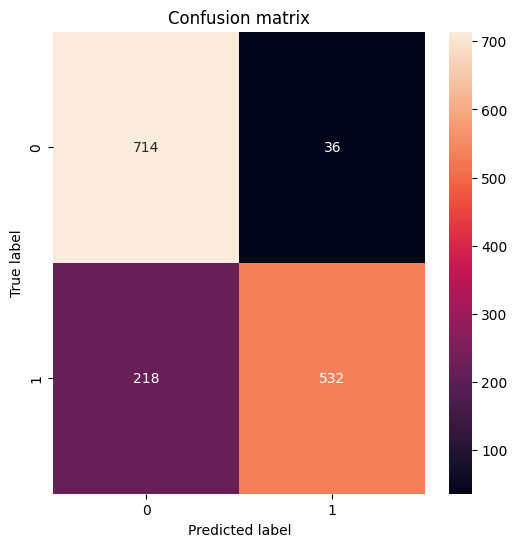

In [41]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	